In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/robust ML/Assignment_1')

FileNotFoundError: ignored

In [1]:
#### Homework Assignment 1: Adversarial Examples

## This jupyter notebook aims to get familiar with the untargted and targeted methods for generating adversarial examples
## We will try to attack a pretrained ImageNet ResNet50 model on a given ImageNet image .

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

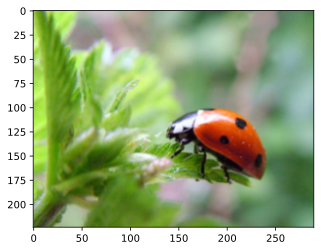

In [2]:
## Load the sample ImageNet image (which is an image of ladybug) and visualize it

from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
ladybug_img = Image.open("ladybug.jpg")

preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
ladybug_tensor = preprocess(ladybug_img)[None,:,:,:]
# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(ladybug_tensor[0].permute(1,2,0).numpy())#.transpose(1,2,0)) deos the same but transpose is designed specifically for 2 D matrices


In [3]:
## Prepare the ImageNet ResNet50 classification model
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode
model = resnet50(pretrained=True)
model.eval()

c:\Users\prath\anaconda3\envs\tf-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prath\anaconda3\envs\tf-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}## dictionary {label_number(int): 'class_name'(string)}

# form the prediction on the clean ladybug image
pred_ladybug = model(norm(ladybug_tensor))
print(imagenet_classes[pred_ladybug.max(dim=1)[1].item()]) ## tensor.max() return both the value and the index loc[0]:value loc[1]:index

ladybug


In [5]:
# 301 is the class index corresponding to the ImageNet class "ladybug"
# form the cross-entropy loss on the prediction according to the ground truth label
print(nn.CrossEntropyLoss()(model(norm(ladybug_tensor)),torch.LongTensor([301])).item())

0.07101953774690628


In [ ]:
## Your task 1: implement the simple version of untargeted PGD attack - make necessary changes to the following code
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
epsilon = 2./255
# delta stores the generated perturbation and updates its value iteratively
delta = torch.zeros_like(ladybug_tensor,requires_grad=True)

criterion = nn.CrossEntropyLoss()
for t in range(30):
    pred = model(norm(ladybug_tensor+delta))
    with torch.enable_grad():
      loss = criterion(pred,torch.LongTensor([301]))
    loss.backward()
    with torch.no_grad():
      delta.data = (delta.data + 0.1 * delta.grad.sign())
      delta.data = delta.data.clamp(-epsilon,epsilon)
    if t % 5 == 0:
        print(t, loss.item())

# pred stores the model predicted logits of the genreated adversarial example
print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

0 0.07101953774690628
5 13.948640823364258
10 24.1588077545166
15 30.850645065307617
20 35.654441833496094
25 39.894325256347656
True class probability: 6.773011207263421e-19


In [ ]:
## Your task 1: implement the simple version of untargeted PGD attack - make necessary changes to the following code
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
epsilon = 2./255

# delta stores the generated perturbation and updates its value iteratively
delta = torch.zeros_like(ladybug_tensor,requires_grad=True)
optimiser = torch.optim.SGD([delta],lr=0.1)
criterion = nn.CrossEntropyLoss()
for t in range(30):
    optimiser.zero_grad()
    pred = model(norm(ladybug_tensor+delta))
    with torch.enable_grad():
      loss = -criterion(pred,torch.LongTensor([301]))
    loss.backward()
    optimiser.step()
    if t % 5 == 0:
        print(t, loss.item())

# pred stores the model predicted logits of the genreated adversarial example
print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

0 -0.07101953774690628
5 -9.945606231689453
10 -24.097124099731445
15 -38.376625061035156
20 -48.61430740356445
25 -56.056941986083984
True class probability: 9.262064806820487e-28


In [ ]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  leaf_beetle
Predicted probability: 0.9974428415298462


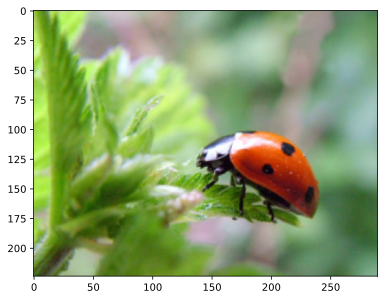

In [ ]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

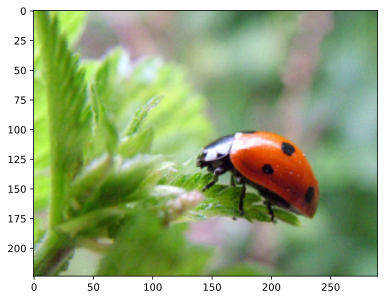

In [ ]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

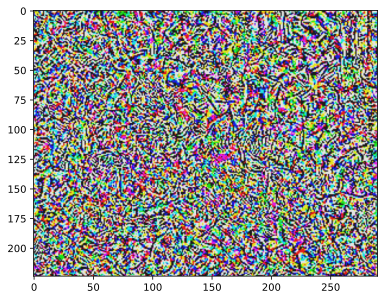

In [ ]:
# plot the generated adversarial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [ ]:
## Your task 2: implement the basic version of targeted attack - make necessary changes to the following code
## Targeted label: zebra; Class index: 340
epsilon = 2./255
# delta stores the generated perturbation and updates its value iteratively
delta = torch.zeros_like(ladybug_tensor,requires_grad=True)
criterion = nn.CrossEntropyLoss()
for t in range(100):
    pred = model(norm(ladybug_tensor+delta))
    with torch.enable_grad():
      loss = criterion(pred,torch.LongTensor([360]))
    loss.backward()
    with torch.no_grad():
      delta.data = (delta.data - 0.1 * delta.grad.sign())
      delta.data = delta.data.clamp(-epsilon,epsilon)

    if t % 10 == 0:
        print(t, loss.item())

print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

0 19.12038230895996
10 0.018356209620833397
20 0.007620549760758877
30 0.005140658468008041
40 0.004056321922689676
50 0.003349767066538334
60 0.0028905775398015976
70 0.0025057366583496332
80 0.002204132964834571
90 0.00201534666121006
True class probability: 8.15358816907974e-07


In [ ]:
## Your task 2: implement the basic version of targeted attack - make necessary changes to the following code
## Targeted label: zebra; Class index: 340
epsilon = 2./255
# delta stores the generated perturbation and updates its value iteratively
delta = torch.zeros_like(ladybug_tensor,requires_grad=True)
optimiser = torch.optim.SGD([delta],lr=0.1)
criterion = nn.CrossEntropyLoss()
for t in range(100):
    optimiser.zero_grad()
    pred = model(norm(ladybug_tensor+delta))
    with torch.enable_grad():
      loss = criterion(pred,torch.LongTensor([340]))
    loss.backward()
    optimiser.step()
    #with torch.no_grad():
     # delta.data = (delta.data - 0.1 * delta.grad.sign())
     # delta.data = delta.data.clamp(-epsilon,epsilon)

    if t % 10 == 0:
        print(t, loss.item())

print("True class probability:", nn.Softmax(dim=1)(pred)[0,301].item())

0 19.54693031311035
10 0.0035770260728895664
20 0.0019702562130987644
30 0.0014223469188436866
40 0.0011304186191409826
50 0.0009422629955224693
60 0.0008104139124043286
70 0.0007138088112697005
80 0.0006388768670149148
90 0.0005789510905742645
True class probability: 4.000116504698781e-08


In [ ]:
## check the predicted class of the generated adversarial example and its prediction probability
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  zebra
Predicted probability: 0.9994658827781677


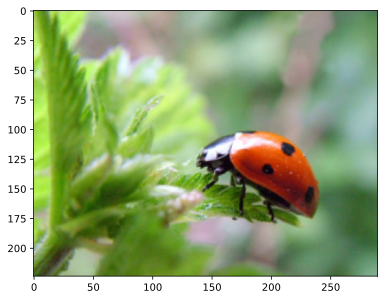

In [ ]:
# plot the original ladybug image
plt.imshow(ladybug_tensor[0].detach().numpy().transpose(1,2,0))

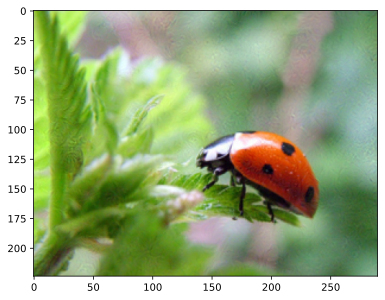

In [ ]:
# plot the adversarially perturbed ladybug image
plt.imshow((ladybug_tensor + delta)[0].detach().numpy().transpose(1,2,0))

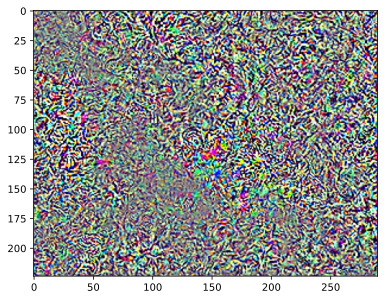

In [ ]:
# plot the generated adversasrial perturbation
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))